# Email Analysis and Classification for SPAM Detection

**Project Description**

A company specialized in Artificial Intelligence–based automation, aims to develop a software library for analyzing and classifying incoming emails.  
The main objective is to identify **SPAM emails** in order to perform in-depth content analysis and improve the security of corporate communications.

The project originates from the CEO’s need to better understand **trends, content, and behaviors** associated with SPAM emails. These insights will be used to:
- enhance anti-spam filters;
- strengthen communication security;
- support strategic decisions in the cybersecurity domain.

---

**Project Objectives**

Based on an email dataset provided by the CTO, the project aims to:

- Train a **classifier** to identify SPAM emails.
- Identify the **main topics** among emails classified as SPAM.
- Compute the **semantic distance between topics** to evaluate the heterogeneity of SPAM content.
- Extract information about **organizations mentioned** in **NON-SPAM** emails.


**Dataset**

👉 https://github.com/ProfAI/natural-language-processing/tree/main/datasets/Verifica%20Finale%20-%20Spam%20Detection


## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from wordcloud import WordCloud
from scipy.spatial.distance import cosine
from collections import Counter

import re

# nlp imports
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import spacy
from spacy.lang.en import English

from pprint import pprint

from gensim.models import Word2Vec
from gensim import corpora, models

# models 
from sklearn.cluster import KMeans

'''
from tqdm import tqdm
import time
import joblib
import random

# nlp import
import gensim
from gensim.utils import simple_preprocess
from bertopic import BERTopic

import spacy
import spacy.displacy as displacy



# models 
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report, make_scorer

'''


'\nfrom tqdm import tqdm\nimport time\nimport joblib\nimport random\n\n# nlp import\nimport gensim\nfrom gensim.utils import simple_preprocess\nfrom bertopic import BERTopic\n\nimport spacy\nimport spacy.displacy as displacy\n\n\n\n# models \nfrom sklearn.neural_network import MLPClassifier\nfrom sklearn.cluster import KMeans\nfrom sklearn.linear_model import LogisticRegression \nfrom sklearn.naive_bayes import MultinomialNB\nfrom sklearn.ensemble import RandomForestClassifier\nimport xgboost as xgb\nfrom lightgbm import LGBMClassifier\n\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.preprocessing import MaxAbsScaler\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.base import BaseEstimator, TransformerMixin\nfrom sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate\n\nfrom sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\nfrom sklearn

In [2]:
# Environmnt variables
!python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.6/12.8 MB 7.6 MB/s eta 0:00:02
     --------- ------------------------------ 3.1/12.8 MB 7.7 MB/s eta 0:00:02
     -------------- ------------------------- 4.7/12.8 MB 7.5 MB/s eta 0:00:02
     ------------------- -------------------- 6.3/12.8 MB 7.7 MB/s eta 0:00:01
     ------------------------ --------------- 7.9/12.8 MB 7.6 MB/s eta 0:00:01
     ----------------------------- ---------- 9.4/12.8 MB 7.5 MB/s eta 0:00:01
     ---------------------------------- ----- 11.0/12.8 MB 7.6 MB/s eta 0:00:01
     ---------------------------------------  12.6/12.8 MB 7.6 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 7.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Functions

In [3]:
def normalize_unicode(text):
    return text.encode('utf-8', 'ignore').decode('utf-8', 'ignore')

def remove_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def replace_urls_emails(text):
    url_pattern = re.compile(r'http\S+|www\S+|https\S+')
    return url_pattern.sub(r'url', text)

def remove_headers_tag(text):
    header_pattern = re.compile(r'^(From|To|Subject|Cc|Bcc|Date): ', re.MULTILINE)
    return header_pattern.sub('', text)

def clean_spacing(text):
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'\n+', ' ', text)  
    return text.strip() 

def base_clean(text):
    text = normalize_unicode(text)
    text = remove_html(text)
    text = replace_urls_emails(text)
    text = remove_headers_tag(text)
    text = clean_spacing(text)
    return text

In [ ]:
def topic_embedding(words, w2v_model):
    # Compute the mean vector for a list of words and a given Word2Vec model
    vectors = [w2v_model.wv[w[0]] for w in words if w[0] in w2v_model.wv]
    return np.mean(vectors, axis=0)

## Load Dataset

In [4]:
link_dataset = "https://raw.githubusercontent.com/ProfAI/natural-language-processing/refs/heads/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/spam_dataset.csv"

In [5]:
df = pd.read_csv(link_dataset)
df

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\nthe transport v...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\nhpl ...,0
5168,2933,ham,Subject: calpine daily gas nomination\n>\n>\nj...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [6]:
df = df.drop(columns=['Unnamed: 0'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [8]:
df['clean_text'] = df['text'].apply(base_clean)

In [9]:
n=1000

In [10]:
df['text'][n]

'Subject: logistics enom team\nhal , as per our discussion here are the logistics people that will be\ndedicated to the enom development :\nkey subject experts :\nthe logistics managers for each of the various regions will be the key\nsubject expert and will pull in the added resources ( individual pipeline\nschedulers ) for the really detailed work . as far as time dedicated we will\ncommit to as much time as needed with the understanding that these\nindividuals do have the responsibility for managing all of the scheduling\nactivity in their regions . bottom line is during bid - week and when\nemergencies develop they will be needed at their trading desks . all meetings\nwith these individuals should be scheduled for the afternoon .\nkathy kelly - northeast\ned terry - southeast\nrandy gay - west\ngeorge smith - central\ndarren farmer - texas\nproject steering team :\nbob superty\nrandy gay\ngeorge smith\nas discussed we might have to bring in others when the product starts to take\ns

In [11]:
df['clean_text'][n]

'logistics enom team hal , as per our discussion here are the logistics people that will be dedicated to the enom development : key subject experts : the logistics managers for each of the various regions will be the key subject expert and will pull in the added resources ( individual pipeline schedulers ) for the really detailed work . as far as time dedicated we will commit to as much time as needed with the understanding that these individuals do have the responsibility for managing all of the scheduling activity in their regions . bottom line is during bid - week and when emergencies develop they will be needed at their trading desks . all meetings with these individuals should be scheduled for the afternoon . kathy kelly - northeast ed terry - southeast randy gay - west george smith - central darren farmer - texas project steering team : bob superty randy gay george smith as discussed we might have to bring in others when the product starts to take shape and is impacting other are

# EDA

In [12]:
df.isna().sum()

label         0
text          0
label_num     0
clean_text    0
dtype: int64

In [13]:
counts = df['label'].value_counts()
display(counts)

label
ham     3672
spam    1499
Name: count, dtype: int64

In [14]:
spam_ratio = counts.iloc[1]/counts.iloc[0]
print(f"Spam to Ham ratio: {spam_ratio:.2f}")

Spam to Ham ratio: 0.41


<BarContainer object of 2 artists>

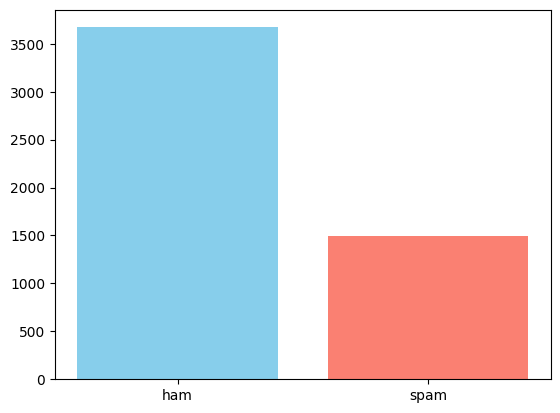

In [15]:
plt.bar(df['label'].value_counts().index, df['label'].value_counts().values, color=['skyblue', 'salmon'])

🧐 Observation:

In the dataset there aren't Nan values.

As usual in these use cases the target feature is unbalanced with the fail category (*spam*) with less samples (3672 vs 1499) and a $ \text{spam/ham ratio} = 0.41 $. 

During the training we're going to explore some methodologies like SMOTE, under and over sampling and check if those will give us better performance.

In [16]:
def tokenize_text(text):
    doc = nlp(text)
    return doc

In [17]:
df['tokens'] = df['clean_text'].apply(tokenize_text)

In [18]:
all_tokens = [t for doc in df["tokens"] for t in doc]
lengths = [len(t) for t in all_tokens]
iqr = np.percentile(lengths, 75) - np.percentile(lengths, 25)
upper_bound_outlier = np.percentile(lengths, 75) + 1.5 * iqr
median = np.median(lengths)

In [19]:
summary_txt = f"Median: {median}\nMin length outliers: {upper_bound_outlier}"

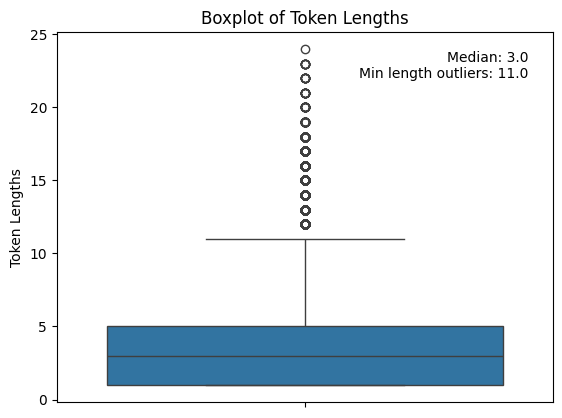

In [20]:
ax = sns.boxplot(lengths)
ax.set_title("Boxplot of Token Lengths")
ax.set_ylabel("Token Lengths")
ax.text(
    0.95, 0.95,              # alto a destra
    summary_txt,
    transform=ax.transAxes,  # coordinate relative all'asse
    ha='right',
    va='top',
    fontsize=10
)

plt.show()

## Topic Modeling on Spam

**Pre-processing**:

- ✔️ Lowercasing
- ✔️ Tokenizzazione
- ✔️ Rimozione stopword
- ✔️ Lemmatizzazione
- ✔️ Rimozione punteggiatura
- ✔️ Filtraggio token troppo corti/lunghi
- ✔️ Word Embedding

In [21]:
def filter_tokens (doc):
    tokens = [
        token.lemma_.lower()    # lemmatization and lowercasing
        for token in doc
        if not token.is_punct   # removing punctuation
        and not token.is_stop   # removing stopwords
        and token.is_alpha      # removing non-alphabetic tokens
        and 3 <= len(token) <= 15  # choose from the boxplot
        ]
    return tokens

In [22]:
df['tokens_cleaned'] = df['tokens'].apply(filter_tokens)

In [23]:
spam = df[df['label'] == 'spam']

In [24]:
documents_spam = spam['tokens_cleaned'].tolist()

In [25]:
word_freq = Counter()
for doc in documents_spam:
    word_freq.update(doc)

### LDA

In [26]:
# Dictionary
dictionary = corpora.Dictionary(documents_spam)
dictionary.filter_extremes(no_below=3, no_above=0.5)

# BoW
corpus = [dictionary.doc2bow(doc) for doc in documents_spam]
# LDA
lda_model = models.LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    passes=10,
    random_state=42
)

In [27]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"nbsp" + 0.009*"account" + 0.006*"money" + 0.006*"email" + '
  '0.005*"number" + 0.005*"claim" + 0.005*"million" + 0.005*"bank" + '
  '0.004*"address" + 0.004*"fund"'),
 (1,
  '0.023*"company" + 0.013*"statement" + 0.011*"stock" + 0.009*"information" + '
  '0.008*"report" + 0.008*"security" + 0.008*"investment" + 0.006*"price" + '
  '0.006*"inc" + 0.006*"look"'),
 (2,
  '0.013*"http" + 0.011*"pill" + 0.010*"com" + 0.008*"good" + 0.006*"price" + '
  '0.006*"online" + 0.006*"new" + 0.005*"viagra" + 0.005*"save" + '
  '0.005*"want"'),
 (3,
  '0.016*"com" + 0.012*"computron" + 0.010*"www" + 0.009*"contact" + '
  '0.008*"message" + 0.008*"remove" + 0.007*"free" + 0.006*"send" + '
  '0.006*"link" + 0.006*"mail"'),
 (4,
  '0.024*"font" + 0.020*"http" + 0.017*"height" + 0.014*"width" + 0.012*"size" '
  '+ 0.011*"align" + 0.011*"com" + 0.009*"border" + 0.009*"color" + '
  '0.009*"href"')]


In [28]:
lda_topics = lda_model.show_topics(
    num_topics=lda_model.num_topics,
    num_words=100,
    formatted=False
)

In [29]:
lda_topics

[(0,
  [('nbsp', np.float32(0.019210601)),
   ('account', np.float32(0.009378199)),
   ('money', np.float32(0.0063436776)),
   ('email', np.float32(0.0057332856)),
   ('number', np.float32(0.005321771)),
   ('claim', np.float32(0.0052948236)),
   ('million', np.float32(0.004936165)),
   ('bank', np.float32(0.00473559)),
   ('address', np.float32(0.0044971155)),
   ('fund', np.float32(0.0042333184)),
   ('business', np.float32(0.0039818874)),
   ('transfer', np.float32(0.0038783187)),
   ('contact', np.float32(0.0037477452)),
   ('security', np.float32(0.0035114454)),
   ('international', np.float32(0.0034975011)),
   ('program', np.float32(0.0032380396)),
   ('company', np.float32(0.0031746083)),
   ('country', np.float32(0.003124725)),
   ('com', np.float32(0.0031176915)),
   ('prize', np.float32(0.0030850316)),
   ('mail', np.float32(0.0030541706)),
   ('transaction', np.float32(0.0027915752)),
   ('die', np.float32(0.002717786)),
   ('year', np.float32(0.0027174265)),
   ('fax', np.

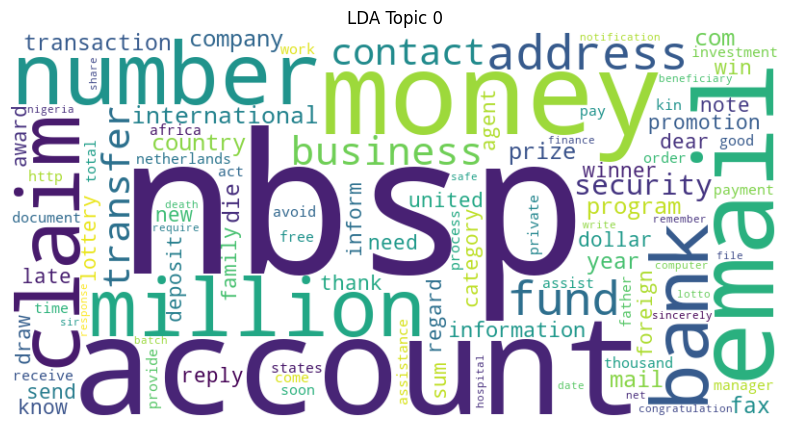

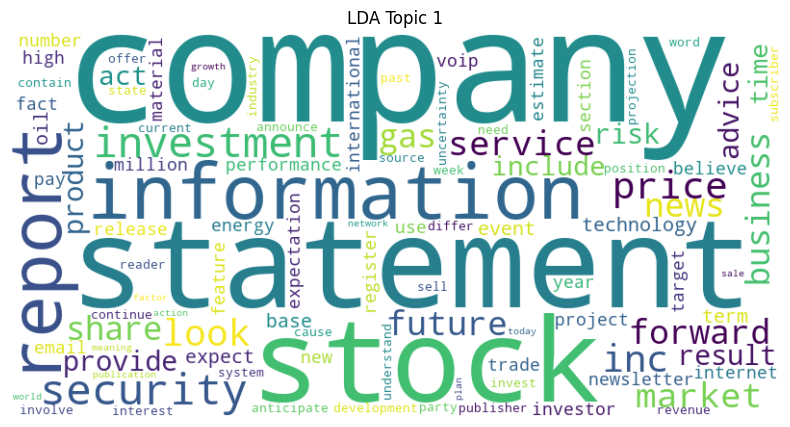

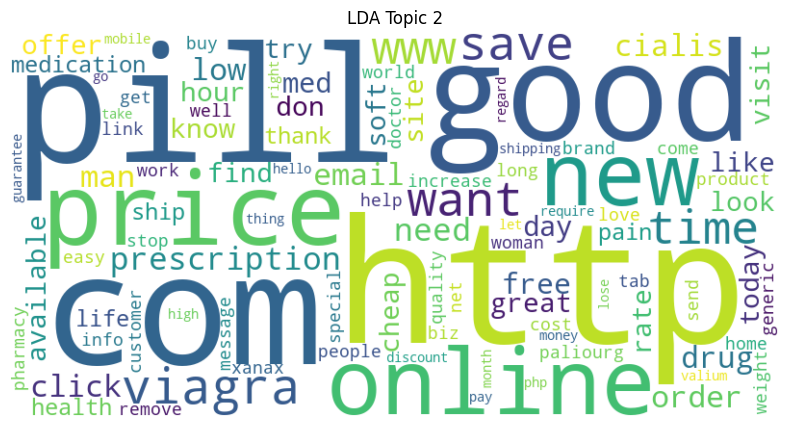

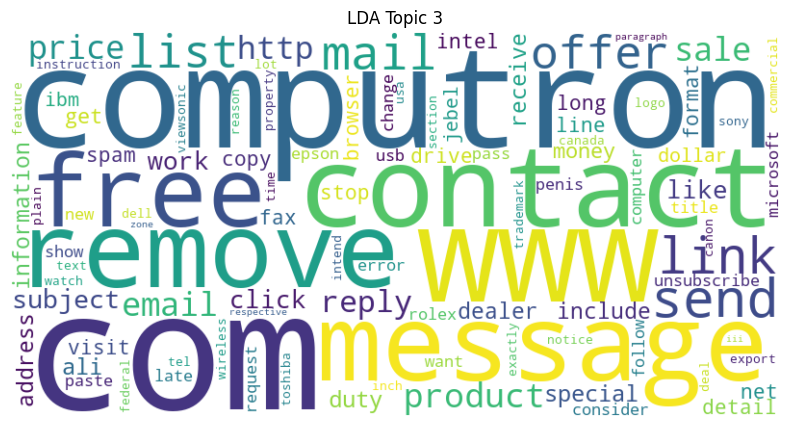

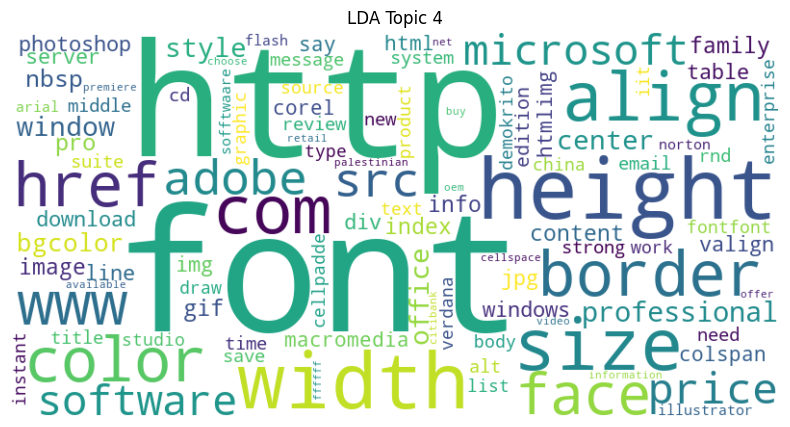

In [30]:
# WordCloud LDA con probabilità delle parole nei topic
for topic_id, words in lda_topics:
    # Converti in dict {word: weight}
    word_freq = dict(words)

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"LDA Topic {topic_id}")
    plt.show()


🔍 TOPIC DESCRIPTION

- **Topic 0: Financial Fraud, Lottery & Payment**: this topic is highly associated with financial scam like requests or promises of money, fake winnings, prizes, or blocked funds, requests for bank transfers, account, security, and contact information

    -> (*money, account, amount, fund, transfer, payment, dollar, prize, winner, security, contact, address, transaction*)

- **Topic 1: Business, Investment & Corporate Communication**: this topic concerns the world of business communication and speculative finance, these are emails promoting stock market investments, often linked to “pump and dump” schemes, the language used is that of financial reports and corporate communications to appear credible to potential investors

    -> (*company, statement, stock, investment, market, price, service, information, security, report, result, future, growth*)

- **Topic 2: Pharmaceutical & Product Promotion**: this topic focuses on the sale of medicines (often counterfeit) without the need for a prescription, the words emphasize savings and the ease of online purchasing, with specific references to male health products


    -> (*product, price, order, low, discount, online, click, buy, drug, prescription, viagra, cialis, free, cheap, shipping*)

- **Topic 3: Commercial Marketing and Mailing Lists**: this topic seems to group together generic commercial spam or unsolicited newsletters, It includes offers for various products and messages inviting recipients to click on links to “remove” themselves from a list or to view an offer, this is spam that attempts to generate traffic to specific websites or validate active email addresses

    -> (*computron, free, contact, remove, email, click, message, link, unsubscribe*)

- **Topic 4: Software and HTML Formatting (Technical)**: this topic  is a mix of software promotion and technical “noise” in messages, it reflects the sale of counterfeit or low-cost software (Adobe, Microsoft) and the massive presence of technical HTML terms indicates that the model has captured the structure of the code used to create graphically rich emails, typical of modern spam templates

    -> ( *http, font, width, size, height, href, color, adobe, microsoft, software, photoshop, windows.*)

### W2v + KMeans

In [31]:
w2v_model = Word2Vec(
    sentences=documents_spam,  # la lista di token
    vector_size=100,      # dimensione embedding
    window=5,             # finestra contesto
    min_count=3,          # ignora parole rare
    workers=4,            # numero di thread
    sg=1,                 # 1=skip-gram, 0=CBOW
    seed=42
)

In [32]:
vocab = list(w2v_model.wv.index_to_key)
word_vectors = np.array([w2v_model.wv[word] for word in vocab])

In [33]:
# KMeans clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(word_vectors)
word_clusters = {word: kmeans.labels_[i] for i, word in enumerate(vocab)}
cluster_centers = kmeans.cluster_centers_

In [34]:
word_freq = Counter()
for doc in documents_spam:
    word_freq.update(doc)

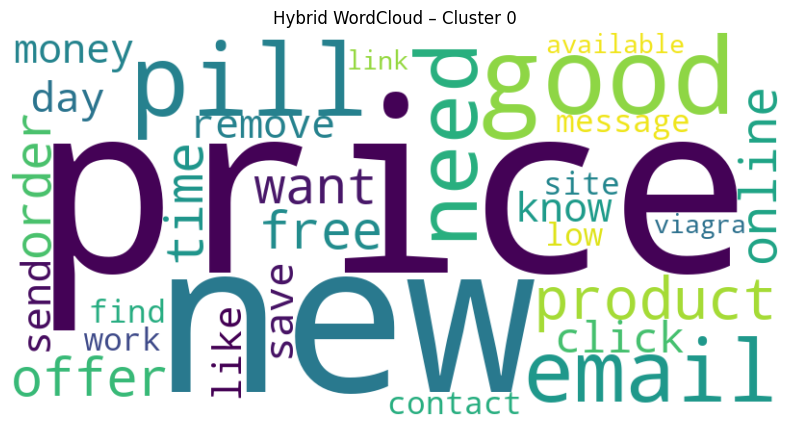

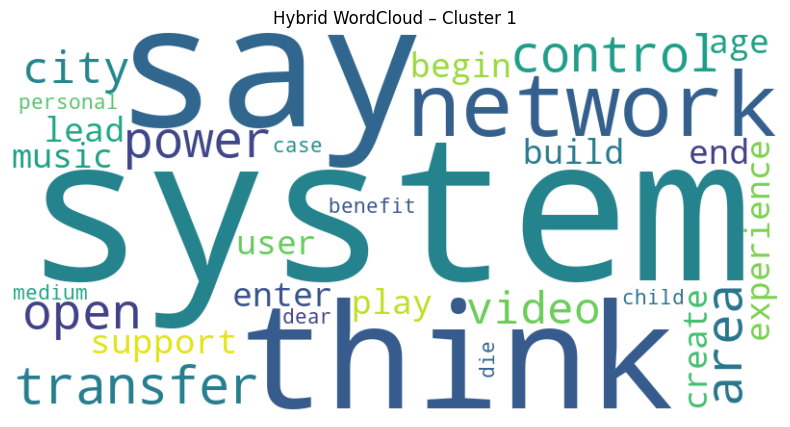

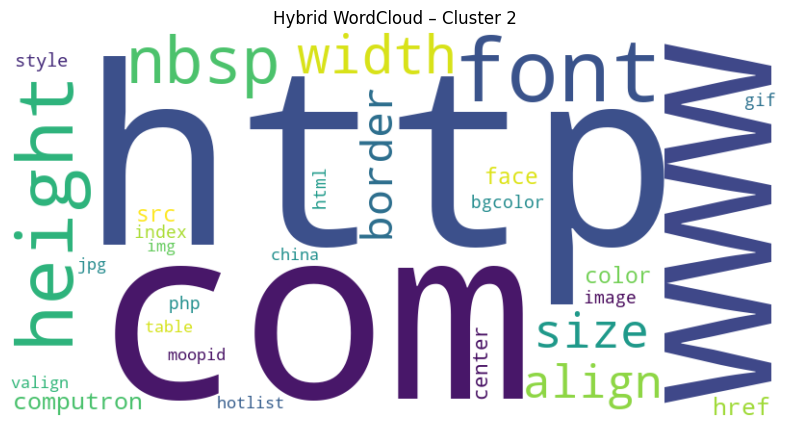

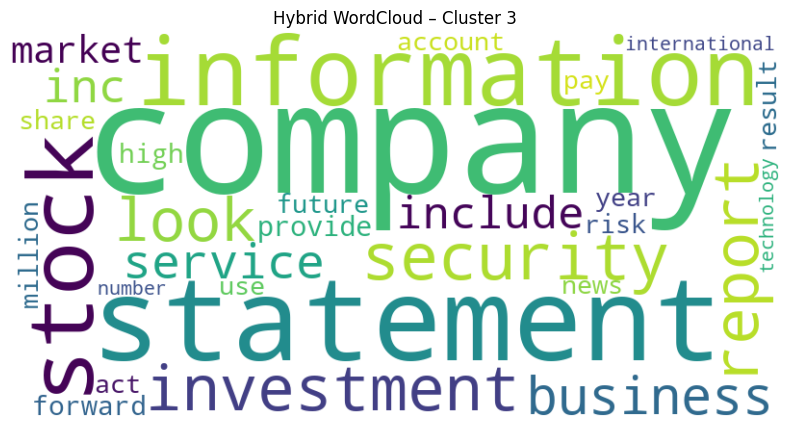

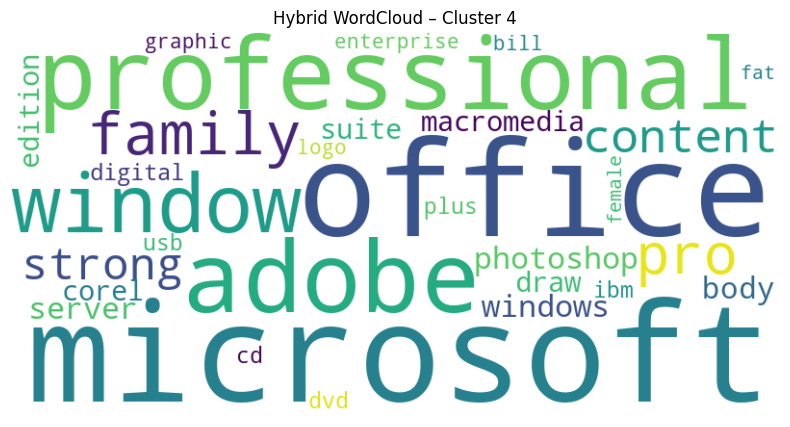

In [35]:
for cluster_id in range(num_clusters):
    cluster_words = [word for word, c in word_clusters.items() if c == cluster_id]


    weights = {}
    for word in cluster_words:
        sim = 1 - cosine(w2v_model.wv[word], cluster_centers[cluster_id])
        weights[word] = word_freq[word]*sim

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=30
    ).generate_from_frequencies(weights)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Hybrid WordCloud – Cluster {cluster_id}")
    plt.show()


🔍 CLUSTER DESCRIPTION

- **Cluster 0: Commercial Offers and Online Pharmacy**: This cluster aimed at the direct sale of products, with a strong emphasis on the pharmaceutical sector, focuses on promoting “new products” and “offers” at attractive prices

    -> (*price, new, pill, good, product, offer, viagra, order, online, free*);

- **Cluster 1: General Communication and Tech Services**: This cluster appears less specific than the previous ones, collecting emails that use conversational language or language related to network and entertainment services, seems to group emails that simulate discussions or offer multimedia services and technical support 

    -> (*system, think, say, network, video, user, support, play, music, power*);

- **Cluster 2: Technical Structure and Junk HTML**: This cluster is purely technical, represents the “noise” of the HTML code used to compose graphical spam emails 

    -> (*http, com, font, width, height, align, border, size, src, href, style*);

-  **Cluster 3: Corporate Finance and Stock Market**: This cluster is dedicated to fraud or promotions in the economic sphere 

    -> (*company, information, statement, stock, investment, security, report, share, business*);

- **Cluster 4: Professional Software Sales**: This cluster is highly vertical and focused on software distribution often counterfeit or at ridiculously low prices, the brands mentioned are the giants of the industry 

    -> (*microsoft, office, professional, adobe, window, suite, photoshop, macromedia, pro*)

### Comparison of 2 methods

In [36]:
lda_topics_dict = {topic_id: list(words) for topic_id, words in lda_topics}

In [38]:
topic_cluster_distr = pd.DataFrame(columns=['LDA_topic', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4'])

# Per ogni topic LDA, vediamo in quali cluster KMeans finiscono le parole
for topic_id, words in lda_topics_dict.items():
    clusters_in_topic = []
    for word in words:
        #print(word)
        if word[0] in word_clusters.keys():
            clusters_in_topic.append(word_clusters[word[0]])
    #print(clusters_in_topic)
    counter = Counter(clusters_in_topic)
    topic_cluster_distr.at[topic_id, 'LDA_topic'] = topic_id
    for cluster_num in range(num_clusters):
        col_name = f'Cluster_{cluster_num}'
        topic_cluster_distr.at[topic_id, col_name] = counter.get(cluster_num, 0)
        
    print(f"LDA Topic {topic_id} distribution over Word2Vec clusters: {counter}")


LDA Topic 0 distribution over Word2Vec clusters: Counter({np.int32(3): 50, np.int32(0): 32, np.int32(1): 13, np.int32(2): 3, np.int32(4): 2})
LDA Topic 1 distribution over Word2Vec clusters: Counter({np.int32(3): 85, np.int32(0): 13, np.int32(1): 2})
LDA Topic 2 distribution over Word2Vec clusters: Counter({np.int32(0): 92, np.int32(2): 4, np.int32(3): 4})
LDA Topic 3 distribution over Word2Vec clusters: Counter({np.int32(0): 64, np.int32(2): 16, np.int32(3): 14, np.int32(4): 5, np.int32(1): 1})
LDA Topic 4 distribution over Word2Vec clusters: Counter({np.int32(2): 38, np.int32(0): 29, np.int32(4): 26, np.int32(1): 4, np.int32(3): 3})


In [ ]:
topic_cluster_distr

,LDA_topic,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,0,32,13,3,50,2
1,1,13,2,0,85,0
2,2,92,0,4,4,0
3,3,64,1,16,14,5
4,4,29,4,38,3,26


🤔 Consideration

The distribution of the words frequencies between *Clusters* and *Topics* is alligned with their contents. We can assert that there are some main topics in the spam emails:
- Business and Corporate communications, Financial fraud and Lottery win
- Pharmaceutical and product promotion
- Software promotion and HTML formatting
- Marketing and commercial offers

### Semantic distance

In [126]:
# Vetorization of LDA topics and KMeans clusters
lda_vectors = {
    topic_id: topic_embedding(words, w2v_model)
    for topic_id, words in lda_topics_dict.items()
}
cluster_vectors = {i: np.mean([w2v_model.wv[w] for w, c in word_clusters.items() if c==i], axis=0) for i in range(num_clusters)}

In [ ]:
# Compute distance matrix between LDA topics and KMeans clusters
dist_matrix_tc = np.array([[0.0 for _ in range(len(lda_vectors))] for _ in range(len(lda_vectors))])
for t1_id, t1_vector in lda_vectors.items():
    for t2_id, t2_vector in cluster_vectors.items():
            dist_matrix_tc[t1_id][t2_id] = cosine(t1_vector, t2_vector)
            # print(f"Distance Topic {t1_id} - Cluster {t2_id}: {dist_matrix_tc[t1_id][t2_id]:.3f}")

Distance Topic 0 - Cluster 0: 0.164
Distance Topic 0 - Cluster 1: 0.146
Distance Topic 0 - Cluster 2: 0.372
Distance Topic 0 - Cluster 3: 0.130
Distance Topic 0 - Cluster 4: 0.395
Distance Topic 1 - Cluster 0: 0.255
Distance Topic 1 - Cluster 1: 0.157
Distance Topic 1 - Cluster 2: 0.529
Distance Topic 1 - Cluster 3: 0.015
Distance Topic 1 - Cluster 4: 0.420
Distance Topic 2 - Cluster 0: 0.012
Distance Topic 2 - Cluster 1: 0.184
Distance Topic 2 - Cluster 2: 0.317
Distance Topic 2 - Cluster 3: 0.319
Distance Topic 2 - Cluster 4: 0.414
Distance Topic 3 - Cluster 0: 0.106
Distance Topic 3 - Cluster 1: 0.138
Distance Topic 3 - Cluster 2: 0.213
Distance Topic 3 - Cluster 3: 0.261
Distance Topic 3 - Cluster 4: 0.311
Distance Topic 4 - Cluster 0: 0.173
Distance Topic 4 - Cluster 1: 0.115
Distance Topic 4 - Cluster 2: 0.067
Distance Topic 4 - Cluster 3: 0.408
Distance Topic 4 - Cluster 4: 0.087


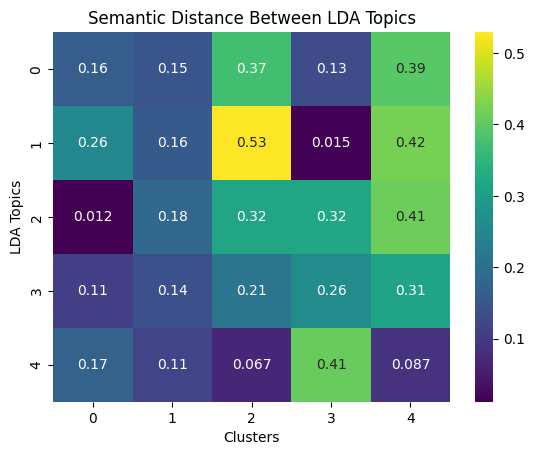

In [139]:
sns.heatmap(dist_matrix_tc, annot=True, cmap="viridis")
plt.title("Semantic Distance Between LDA Topics")
plt.xlabel("Clusters")
plt.ylabel("LDA Topics")
plt.show()

🤔 Consideration

With this visualization of semantic distance between LDA topics and KMeans Clusters we can measure the coerence between the 2 methods of finding groups of similar spam emails.

In this case we evaluate the most similar groups like:
- Topic 0 -> Cluster 3, 1
- Topic 1 -> Cluster 3
- Topic 2 -> Cluster 0
- Topic 3 -> Cluster 0, 1
- Topic 4 -> Cluster 2, 4

In [140]:
dist_matrix_topics = np.array([[0.0 for _ in range(len(lda_vectors))] for _ in range(len(lda_vectors))])
mask = np.triu(np.ones_like(dist_matrix_topics, dtype=bool))
for t1_id, t1_vector in lda_vectors.items():
    for t2_id, t2_vector in lda_vectors.items():
        if t1_id < t2_id:
            dist_matrix_topics[t1_id][t2_id] = cosine(t1_vector, t2_vector)
            dist_matrix_topics[t2_id][t1_id] = cosine(t1_vector, t2_vector)
            print(f"Distance Topic {t1_id}-{t2_id}: {dist_matrix_topics[t1_id][t2_id]:.3f}")

Distance Topic 0-1: 0.148
Distance Topic 0-2: 0.198
Distance Topic 0-3: 0.107
Distance Topic 0-4: 0.292
Distance Topic 1-2: 0.280
Distance Topic 1-3: 0.250
Distance Topic 1-4: 0.406
Distance Topic 2-3: 0.140
Distance Topic 2-4: 0.215
Distance Topic 3-4: 0.164


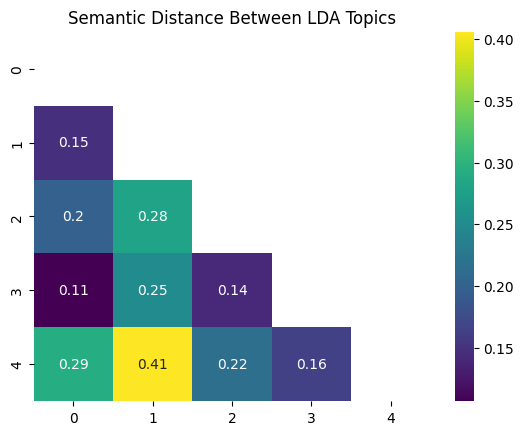

In [141]:
sns.heatmap(dist_matrix_topics, annot=True, cmap="viridis", mask=mask)
plt.title("Semantic Distance Between LDA Topics")
plt.show()

🤔 Consideration

In the semantic distance analysis between LDA topics we can observe only a slightly separation of the groups with cosine distance in range [0.11, 0.29]. The two topics with the most semantic difference are 1 and 4 with a value of 0.41 (not even that high). So the topics are very similar each other.

This could be due to the common lexicon used in the spam-type emails, even with different target areas (financial, pharmaceutical, software).

## NER: find organizations in NON-SPAM e-mails

**Pre-processing**:

- ✔️ Tokenizzazione
- ✔️ Mantenere case originale
- ✔️ Mantenere punteggiatura
- ✔️ NO stopword removal
- ✔️ NO lemmatizzazione

In [ ]:
no_spam = df[df['label'] == 'ham']

# Classifier Model

**Pre-processing**:

- ✔️ Lowercasing
- ✔️ Tokenizzazione
- ✔️ Rimozione stopword
- ✔️ Lemmatizzazione
- ✔️ Rimozione punteggiatura
- ✔️ Filtraggio token rari